In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing
Run the following cell to generate the folder for the Torch ImageLoader class.
The cell requires a labels.csv file which contains the filenames 
of the image files and corresponding resistivity labels (which can be extended
from binary to multiclass depending on resistivity threshold)

In [ ]:
# find closest image to resistivity timestamp
#def find_closest_image(ts):
    # Given a presorted list of timestamps:  s = sorted(index)
#    i = bisect_left(s, ts)
#    return min(s[max(0, i-1): i+2], key=lambda t: abs(ts - t))

import io
import csv
import shutil
img_folder = 'data/timelapse_images_fast'

with open('data/labels_v2.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        img_name = row[1]
        label = int(row[2]=='True') # or label = row[2]
        
        month_folder = row[0][:10]
        #print(month_folder)
        #print(img_name,label)
        #print(os.path.join(img_folder,month_folder,img_name))
        shutil.copyfile(os.path.join(img_folder,month_folder,img_name),os.path.join(img_folder,str(label),img_name))

In [15]:
import os
import torch
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as Ft

import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [16]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
## This class is part of the transforms pipeline used by the DataLoader and generates
## a number of crops according to the list of coord given at initialization
class MyCrop(object):
    def __init__(self, size, coord, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        self.size = size
        self.padding = padding
        # center points
        self.coord = coord
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    def _get_image_size(img):
        return img.shape
    
    def __call__(self, img):
        if self.padding is not None:
            img = Ft.pad(img, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = Ft.pad(img, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = Ft.pad(img, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
        
        crops = []
        for coord in self.coord:
            crops.append(Ft.crop(img, coord[0], coord[1], self.size, self.size))

        return crops

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


In [24]:
opts = {}
opts['epochs'] = 100
opts['batch_size'] = 64
opts['lr'] = 0.003
opts['nr_classes'] = 2

coord = [(155,321),(201,419),(45,460),(121,158)]
coord_flipped = [(321,155),(419,201),(460,45),(158,121)]

TRAIN_DATA_PATH = "./train_data_3"
TEST_DATA_PATH = "./test_data_3"
TRANSFORM_IMG = transforms.Compose([
    #transforms.CenterCrop(64),
    MyCrop(64,coord),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    #transforms.Resize(256),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225] )
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    MyCrop(64,coord_flipped),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    ])

writer = SummaryWriter()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST)

## here, there are two ways of splitting the data into training and test sets (additional validation 
## set for hyperparameter tuning may also be of use). One is to generate two directories of 
## preprocessed images (train_data and test_data) and use two data loaders and the other is 
## to split the sets on the fly. In the latter case, the issue is the strong time correlation 
## between subsequent images which leads to overoptimistic test scores (can be alleviated by
## commenting out the np.random.shuffle(indices) line)

print(len(train_data.imgs))
# split into (train,val,test)
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.05 * dataset_size))
#np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
#train_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], sampler=train_sampler,  num_workers=4)
#valid_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], sampler=valid_sampler,  num_workers=4)
train_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], shuffle=True,  num_workers=4)
valid_data_loader = data.DataLoader(test_data, batch_size=opts['batch_size'], shuffle=False,  num_workers=4)

#train_iter = iter(train_data_loader)
#test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
#test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

17108


torch.Size([4, 3, 64, 64])


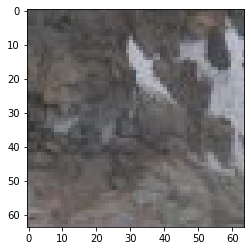

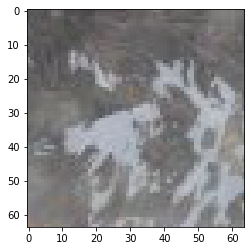

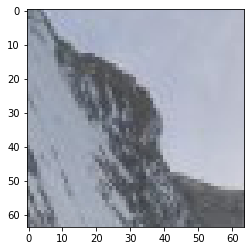

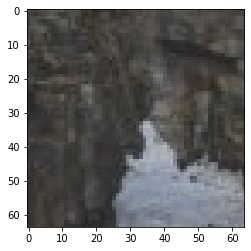

## Models

In [25]:
class BinaryCNN(torch.nn.Module):    
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
class CNN2(nn.Module):
    # initializers
    def __init__(self, d=32, mode='classification'):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(12, d, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        #print(self.conv4_bn)
        if mode=='classification':
            self.linear = nn.Linear(d*8*4*4,3)
        else:
            self.linear = nn.Linear(d*8*4*4,1)
        #self.conv5 = nn.Conv2d(d*8, 4, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = x.reshape(x.size(0), -1)
        #x = F.sigmoid(self.conv5(x))
        x = self.linear(x)

        return x
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training loop

In [26]:
import torch.optim as optim

net = CNN2()
net = net.cuda()
weight = torch.tensor([1/0.63,1/0.21,1/0.15]).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=opts['lr'])
bins = np.array([0,91,182,273,366])
nr_batches = len(train_data_loader)

for epoch in range(opts['epochs']):  
    running_loss = 0.0
    print("Epoch ", epoch)
    for i, sample in tqdm(enumerate(train_data_loader, 0)):
        inputs, labels = sample
        inputs_stack = torch.reshape(inputs,[-1,12,64,64]).cuda()
        labels = labels.cuda()
        # quantize labels to 4 bins
        #labels_q = torch.tensor(np.digitize(labels,bins))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs_stack)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
        # tensorboard 
        writer.add_scalar('Loss/train', loss, epoch*nr_batches + i)
    
    # run on test set
    test_losses = []
    best_loss = 10
    correct = 0
    total = 0
    for i, test_sample in tqdm(enumerate(valid_data_loader, 0)):
        test_inputs, test_labels = test_sample
        test_inputs_stack = torch.reshape(test_inputs,[-1,12,64,64]).cuda()
        test_labels = test_labels.cuda()

        # forward
        test_outputs = net(test_inputs_stack)
        test_loss = criterion(test_outputs, test_labels)
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_losses.append(test_loss)
    
    print("Test accuracy: ", correct/total)
    avg_test_loss = torch.mean(torch.stack(test_losses))
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    writer.add_scalar('Loss/acc', correct/total, epoch)

    if(avg_test_loss < best_loss and epoch > 5):
        torch.save(net.state_dict(), os.path.join('models','best.th'))
    
print('Finished Training')

Epoch  0


268it [00:21, 12.34it/s]
9it [00:02,  3.59it/s]

Test accuracy:  0.5072463768115942
Epoch  1



268it [00:17, 15.59it/s]
9it [00:00, 11.94it/s]

Test accuracy:  0.48731884057971014
Epoch  2



268it [00:17, 15.70it/s]
9it [00:00, 11.62it/s]

Test accuracy:  0.23731884057971014
Epoch  3



268it [00:17, 15.63it/s]
9it [00:00, 11.72it/s]

Test accuracy:  0.3278985507246377
Epoch  4



268it [00:17, 15.59it/s]
9it [00:00, 11.59it/s]

Test accuracy:  0.2246376811594203
Epoch  5



268it [00:17, 15.50it/s]
9it [00:00, 11.53it/s]

Test accuracy:  0.2391304347826087
Epoch  6



268it [00:17, 15.46it/s]
9it [00:00, 11.83it/s]


Test accuracy:  0.3188405797101449
Epoch  7


268it [00:17, 15.64it/s]
9it [00:00, 11.65it/s]

Test accuracy:  0.3605072463768116
Epoch  8



268it [00:17, 15.70it/s]
9it [00:00, 11.91it/s]

Test accuracy:  0.42391304347826086
Epoch  9



268it [00:17, 15.63it/s]
9it [00:00, 11.72it/s]

Test accuracy:  0.4438405797101449
Epoch  10



268it [00:17, 15.72it/s]
9it [00:00, 11.59it/s]

Test accuracy:  0.38768115942028986
Epoch  11



268it [00:17, 15.58it/s]
9it [00:00, 11.80it/s]

Test accuracy:  0.6159420289855072
Epoch  12



268it [00:17, 15.65it/s]
9it [00:00, 11.56it/s]


Test accuracy:  0.5742753623188406
Epoch  13


268it [00:17, 15.68it/s]
9it [00:00, 11.73it/s]


Test accuracy:  0.6322463768115942
Epoch  14


268it [00:17, 15.64it/s]
9it [00:00, 11.59it/s]


Test accuracy:  0.6793478260869565
Epoch  15


268it [00:17, 15.60it/s]
9it [00:00, 11.70it/s]

Test accuracy:  0.6068840579710145
Epoch  16



268it [00:17, 15.67it/s]
9it [00:00, 11.47it/s]


Test accuracy:  0.5144927536231884
Epoch  17


268it [00:17, 15.59it/s]
9it [00:00, 11.72it/s]

Test accuracy:  0.4692028985507246
Epoch  18



268it [00:17, 15.54it/s]
9it [00:00, 10.52it/s]

Test accuracy:  0.5561594202898551
Epoch  19



268it [00:17, 15.46it/s]
9it [00:00, 10.42it/s]


Test accuracy:  0.5887681159420289
Epoch  20


268it [00:17, 15.52it/s]
9it [00:00, 10.59it/s]


Test accuracy:  0.6413043478260869
Epoch  21


268it [00:17, 15.61it/s]
9it [00:00, 10.48it/s]

Test accuracy:  0.6793478260869565
Epoch  22



268it [00:17, 15.60it/s]
9it [00:00, 10.49it/s]


Test accuracy:  0.6213768115942029
Epoch  23


268it [00:17, 15.54it/s]
9it [00:00, 10.65it/s]

Test accuracy:  0.6123188405797102
Epoch  24



268it [00:17, 15.51it/s]
9it [00:00, 10.70it/s]

Test accuracy:  0.6956521739130435
Epoch  25



268it [00:17, 15.54it/s]
9it [00:00, 10.41it/s]

Test accuracy:  0.6485507246376812
Epoch  26



268it [00:17, 15.47it/s]
9it [00:00, 10.59it/s]

Test accuracy:  0.6648550724637681
Epoch  27



268it [00:17, 15.55it/s]
9it [00:00, 10.54it/s]


Test accuracy:  0.625
Epoch  28


268it [00:17, 15.48it/s]
9it [00:00, 10.66it/s]

Test accuracy:  0.7047101449275363
Epoch  29



268it [00:17, 15.59it/s]
9it [00:00, 10.49it/s]


Test accuracy:  0.6539855072463768
Epoch  30


268it [00:17, 15.55it/s]
9it [00:00, 10.54it/s]

Test accuracy:  0.6884057971014492
Epoch  31



268it [00:17, 15.51it/s]
9it [00:00, 10.58it/s]

Test accuracy:  0.697463768115942
Epoch  32



268it [00:17, 15.63it/s]
9it [00:00, 10.47it/s]

Test accuracy:  0.6721014492753623
Epoch  33



268it [00:17, 15.56it/s]
9it [00:00, 10.45it/s]

Test accuracy:  0.572463768115942
Epoch  34



268it [00:17, 15.59it/s]
9it [00:00, 10.50it/s]


Test accuracy:  0.6721014492753623
Epoch  35


268it [00:17, 15.52it/s]
9it [00:00, 10.42it/s]


Test accuracy:  0.6721014492753623
Epoch  36


268it [00:17, 15.57it/s]
9it [00:00, 10.54it/s]


Test accuracy:  0.6956521739130435
Epoch  37


268it [00:17, 15.50it/s]
9it [00:00, 10.51it/s]

Test accuracy:  0.6702898550724637
Epoch  38



268it [00:17, 15.60it/s]
9it [00:00, 10.58it/s]


Test accuracy:  0.6503623188405797
Epoch  39


268it [00:17, 15.52it/s]
9it [00:00, 10.66it/s]

Test accuracy:  0.6467391304347826
Epoch  40



268it [00:17, 15.60it/s]
9it [00:00, 10.59it/s]

Test accuracy:  0.5851449275362319
Epoch  41



268it [00:17, 15.53it/s]
9it [00:00, 10.58it/s]

Test accuracy:  0.6086956521739131
Epoch  42



268it [00:17, 15.57it/s]
9it [00:00, 10.51it/s]


Test accuracy:  0.6847826086956522
Epoch  43


268it [00:17, 15.58it/s]
9it [00:00, 10.58it/s]

Test accuracy:  0.6032608695652174
Epoch  44



268it [00:17, 15.54it/s]
9it [00:00, 10.16it/s]


Test accuracy:  0.6793478260869565
Epoch  45


268it [00:17, 15.59it/s]
9it [00:00, 10.70it/s]

Test accuracy:  0.6829710144927537
Epoch  46



268it [00:17, 15.56it/s]
9it [00:00, 10.74it/s]

Test accuracy:  0.6539855072463768
Epoch  47



268it [00:17, 15.56it/s]
9it [00:00, 10.54it/s]

Test accuracy:  0.6938405797101449
Epoch  48



268it [00:17, 15.56it/s]
9it [00:00, 10.55it/s]

Test accuracy:  0.6684782608695652
Epoch  49



268it [00:17, 15.58it/s]
9it [00:00, 10.54it/s]


Test accuracy:  0.6431159420289855
Epoch  50


268it [00:17, 15.57it/s]
9it [00:00, 10.53it/s]

Test accuracy:  0.7101449275362319
Epoch  51



268it [00:17, 15.57it/s]
9it [00:00, 10.73it/s]

Test accuracy:  0.6485507246376812
Epoch  52



268it [00:17, 15.49it/s]
9it [00:00, 10.52it/s]


Test accuracy:  0.644927536231884
Epoch  53


268it [00:17, 15.57it/s]
9it [00:00, 10.61it/s]

Test accuracy:  0.7010869565217391
Epoch  54



268it [00:17, 15.49it/s]
9it [00:00, 10.59it/s]

Test accuracy:  0.6847826086956522
Epoch  55



268it [00:17, 15.51it/s]
9it [00:00, 10.60it/s]


Test accuracy:  0.6684782608695652
Epoch  56


268it [00:17, 15.54it/s]
9it [00:00, 10.48it/s]


Test accuracy:  0.6956521739130435
Epoch  57


268it [00:17, 15.55it/s]
9it [00:00, 10.34it/s]

Test accuracy:  0.6865942028985508
Epoch  58



268it [00:17, 15.56it/s]
9it [00:00, 10.53it/s]


Test accuracy:  0.6612318840579711
Epoch  59


268it [00:17, 15.53it/s]
9it [00:00, 10.44it/s]


Test accuracy:  0.7192028985507246
Epoch  60


268it [00:17, 15.50it/s]
9it [00:00, 10.55it/s]


Test accuracy:  0.7119565217391305
Epoch  61


268it [00:17, 15.63it/s]
9it [00:00, 10.40it/s]

Test accuracy:  0.6847826086956522
Epoch  62



268it [00:17, 15.55it/s]
9it [00:00, 10.31it/s]

Test accuracy:  0.7101449275362319
Epoch  63



268it [00:17, 15.54it/s]
9it [00:00, 10.55it/s]


Test accuracy:  0.7155797101449275
Epoch  64


268it [00:17, 15.57it/s]
9it [00:00, 10.63it/s]

Test accuracy:  0.697463768115942
Epoch  65



268it [00:17, 15.61it/s]
9it [00:00, 10.58it/s]


Test accuracy:  0.6920289855072463
Epoch  66


268it [00:17, 15.61it/s]
9it [00:00, 10.43it/s]


Test accuracy:  0.7065217391304348
Epoch  67


268it [00:17, 15.53it/s]
9it [00:00, 10.51it/s]


Test accuracy:  0.6992753623188406
Epoch  68


268it [00:17, 15.52it/s]
9it [00:00, 10.47it/s]


Test accuracy:  0.7137681159420289
Epoch  69


268it [00:17, 15.45it/s]
9it [00:00, 10.64it/s]


Test accuracy:  0.7047101449275363
Epoch  70


268it [00:17, 15.54it/s]
9it [00:00, 10.58it/s]

Test accuracy:  0.6920289855072463
Epoch  71



268it [00:17, 15.58it/s]
9it [00:00, 10.58it/s]

Test accuracy:  0.6902173913043478
Epoch  72



268it [00:17, 15.55it/s]
9it [00:00, 10.67it/s]

Test accuracy:  0.730072463768116
Epoch  73



268it [00:17, 15.54it/s]
9it [00:00, 11.82it/s]

Test accuracy:  0.717391304347826
Epoch  74



268it [00:17, 15.62it/s]
9it [00:00, 11.77it/s]


Test accuracy:  0.7137681159420289
Epoch  75


268it [00:17, 15.64it/s]
9it [00:00, 11.80it/s]


Test accuracy:  0.717391304347826
Epoch  76


268it [00:17, 15.63it/s]
9it [00:00, 11.72it/s]

Test accuracy:  0.697463768115942
Epoch  77



268it [00:17, 15.63it/s]
9it [00:00, 11.94it/s]

Test accuracy:  0.6467391304347826
Epoch  78



268it [00:17, 15.62it/s]
9it [00:00, 11.73it/s]

Test accuracy:  0.6884057971014492
Epoch  79



268it [00:17, 15.61it/s]
9it [00:00, 11.87it/s]

Test accuracy:  0.6467391304347826
Epoch  80



268it [00:17, 15.69it/s]
9it [00:00, 11.79it/s]

Test accuracy:  0.6105072463768116
Epoch  81



268it [00:17, 15.64it/s]
9it [00:00, 11.57it/s]

Test accuracy:  0.6594202898550725
Epoch  82



268it [00:17, 15.64it/s]
9it [00:00, 11.69it/s]

Test accuracy:  0.6684782608695652
Epoch  83



268it [00:17, 15.64it/s]
9it [00:00, 11.80it/s]

Test accuracy:  0.6666666666666666
Epoch  84



268it [00:17, 15.67it/s]
9it [00:00, 11.82it/s]


Test accuracy:  0.6811594202898551
Epoch  85


268it [00:17, 15.69it/s]
9it [00:00, 11.93it/s]

Test accuracy:  0.6884057971014492
Epoch  86



268it [00:17, 15.66it/s]
9it [00:00, 11.74it/s]

Test accuracy:  0.6811594202898551
Epoch  87



268it [00:17, 15.54it/s]
9it [00:00, 11.79it/s]

Test accuracy:  0.6231884057971014
Epoch  88



268it [00:17, 15.65it/s]
9it [00:00, 11.89it/s]

Test accuracy:  0.6068840579710145
Epoch  89



268it [00:17, 15.63it/s]
9it [00:00, 11.90it/s]

Test accuracy:  0.6141304347826086
Epoch  90



268it [00:17, 15.64it/s]
9it [00:00, 11.81it/s]

Test accuracy:  0.5307971014492754
Epoch  91



268it [00:17, 15.66it/s]
9it [00:00, 11.63it/s]

Test accuracy:  0.6739130434782609
Epoch  92



268it [00:17, 15.64it/s]
9it [00:00, 11.76it/s]


Test accuracy:  0.6793478260869565
Epoch  93


268it [00:17, 15.63it/s]
9it [00:00, 11.65it/s]


Test accuracy:  0.6231884057971014
Epoch  94


268it [00:17, 15.68it/s]
9it [00:00, 11.75it/s]

Test accuracy:  0.6159420289855072
Epoch  95



268it [00:17, 15.65it/s]
9it [00:00, 11.86it/s]

Test accuracy:  0.6847826086956522
Epoch  96



268it [00:17, 15.64it/s]
9it [00:00, 11.70it/s]


Test accuracy:  0.5489130434782609
Epoch  97


268it [00:17, 15.64it/s]
9it [00:00, 11.65it/s]


Test accuracy:  0.6467391304347826
Epoch  98


268it [00:17, 15.46it/s]
9it [00:00, 11.75it/s]


Test accuracy:  0.6648550724637681
Epoch  99


268it [00:17, 15.71it/s]
9it [00:00, 11.78it/s]

Test accuracy:  0.6086956521739131
Finished Training


## Load trained model and test it visually on a batch

/home/ivan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Predicted label:  tensor(0)
True label:  tensor(0)


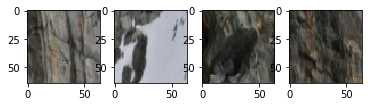

KeyboardInterrupt: 

In [30]:
model = CNN2()
model.load_state_dict(torch.load('models/best.th'))
for batch_idx, sample in enumerate(valid_data_loader):
    images, labels = sample
    test_images_stack = torch.reshape(images,[-1,12,64,64])

    test_labels = model(test_images_stack)
    softmaxlbl = F.softmax(test_labels)
    for i in range(opts['batch_size']):
        print("Predicted label: ", torch.argmax(softmaxlbl[i]))
        print("True label: ", labels[i])
        f, axarr = plt.subplots(1,4)

        axarr[0].imshow(images[i][0].permute(1, 2, 0))
        axarr[1].imshow(images[i][1].permute(1, 2, 0))
        axarr[2].imshow(images[i][2].permute(1, 2, 0))
        axarr[3].imshow(images[i][3].permute(1, 2, 0))
        plt.show()
        #for j in range(4):
        #    plt.imshow(  sample[0][0][j].permute(1, 2, 0)  )
        #    plt.show()
        input("Press key for next sample")

## Misc

In [ ]:
#import seaborn as sns
#data = pd.read_csv("data/timeseries_derived_data_products/MH11_resistivity_rock_2017.csv") 
# Preview the first 5 lines of the loaded data 
data = pd.read_csv("data/labels.csv") 
#pd.DataFrame.plot.line(data)
data

In [ ]:
labels = np.array([2,30,330,102,35,67,82,230])
bins = np.array([1,90,180,270,360])
np.histogram(labels, bins)
np.digitize(labels,bins)

In [ ]:
for batch_idx, sample in enumerate(train_data_loader):
    images, labels = sample
    labels_q = np.digitize(labels,bins)
    plt.imshow(  sample[0][0].permute(1, 2, 0)  )


In [ ]:
max_val = 0
min_val = 100
for i, sample in tqdm(enumerate(train_data_loader, 0)):
    max_tmp = torch.max(sample[1])
    min_tmp = torch.min(sample[1])

    if max_tmp > max_val:
        max_val = max_tmp
    if min_tmp < min_val:
        min_val = min_tmp

print(max_val)
print(min_val)

In [ ]:
resnet18 = models.resnet18()

In [ ]:
for batch_idx, sample in enumerate(train_data_loader):
    images, labels = sample
    print(images[0].shape)
    #labels_q = np.digitize(labels,bins)
    for i in range(4):
        plt.imshow(  sample[0][0][i].permute(1, 2, 0)  )
        plt.show()
    break;